# Overview

This cell provides an overview of what is happening in the code:
1. Pointing at correct directories and resizing all 200,000k images
2. Splitting data into test/train and calling dataloader function
3. Testing for GPU
4. Defining model
5. Training model
6. Loading trained model
7. Plotting biases

In [204]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import glob
import data_utils.data_utils_celeba_pytorch5 as data_utils
import data_utils.network_tuning_valid as network_tuning
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import pickle
import numpy as np
import pandas as pd
import os

## 1. Pointing at correct directories and resizing all 200,000k images

In [205]:
name = "c" #m, c eller a

In [206]:
# Root directory for dataset
if name == "c":
    dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'
elif name =="m" or "a":
    dataroot = "../AlgorithmicFairness"
    
# Batch size during training
batch_size = 128

In [207]:
if name == "c":
    attributes = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\Data\\list_attr_celeba.txt', sep=" ")
    attributes.drop('Unnamed: 41',axis=1, inplace=True)
    partition = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\list_eval_partition.txt', sep=" ", header=None, names=['im_id','partition'])
elif name == "m" or "a":
    attributes = pd.read_csv(dataroot+'/Data/list_attr_celeba.txt', sep=" ")
    attributes.drop('Unnamed: 41',axis=1, inplace=True)
    partition = pd.read_csv(dataroot+'/Data/list_eval_partition.txt', sep=" ", header=None, names=['im_id','partition'])
    
matched = attributes.set_index('im_id').join(partition.set_index('im_id')).replace(-1,0)

In [208]:
train_df = matched[matched['partition']==0]
valid_df = matched[matched['partition']==1]
test_df = matched[matched['partition']==2]
#train_df.to_csv('Data\\train.csv')
#valid_df.to_csv('Data\\valid.csv')
#test_df.to_csv('Data\\test.csv')

In [32]:
#install cv2:
#!pip install opencv-python

In [23]:
resize = False

In [29]:
from PIL import Image
import cv2

if name == "c":
    IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\celebA\\"
    RESIZE_IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\celebA_resize3\\"
elif name =="m":
    IMAGE_PATHS = "/Users/MartinJohnsen/Documents/Martin Johnsen/MMC/3. Semester/Deep Learning/Projects/Algorithmic fairness/Data/celeba/"
    RESIZE_IMAGE_PATHS = "/Users/MartinJohnsen/Documents/Martin Johnsen/MMC/3. Semester/Deep Learning/Projects/Algorithmic fairness/Data/celebA_resize3/"
    
IMAGE_SHAPE = (60,73)

dirs = os.listdir(IMAGE_PATHS)
print(len(dirs))
if resize == True: 
    for item in dirs:
        img_name = os.path.join(IMAGE_PATHS,item)
        #image = Image.open(img_name)
        #image = image.resize(IMAGE_SHAPE, Image.ANTIALIAS)
        #image.save(os.path.join(RESIZE_IMAGE_PATHS,item), format='JPEG', subsampling=0, quality=100)

        img = cv2.imread(img_name, cv2.IMREAD_UNCHANGED)
        resized = cv2.resize(img, IMAGE_SHAPE, interpolation = cv2.INTER_AREA)
        cv2.imwrite(os.path.join(RESIZE_IMAGE_PATHS,item),resized)

202599


In [209]:
#test length of resized:
dirs_re = os.listdir(RESIZE_IMAGE_PATHS)
len(dirs_re)

NameError: name 'RESIZE_IMAGE_PATHS' is not defined

In [210]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(os.path.join(RESIZE_IMAGE_PATHS,item))
imgplot = plt.imshow(img)
plt.show()

Populating the interactive namespace from numpy and matplotlib


C:\Users\cfthe\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'imread', 'tanh', 'resize', 'partition']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


NameError: name 'RESIZE_IMAGE_PATHS' is not defined

## 2. Splitting data into test/train and calling dataloader function

In [211]:
IMAGE_SHAPE = [73,60,3]
# Paths to data
if name == "c": 
    TRAIN_PATH =  dataroot + "\\Data\\train.csv" 
    VALID_PATH = dataroot + "\\Data\\valid.csv" 
    TEST_PATH = dataroot + "\\Data\\test.csv" 
    IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\celebA_resize3\\"
elif name == "m": 
    TRAIN_PATH =  dataroot + "/Data/train.csv" 
    VALID_PATH = dataroot + "/Data/valid.csv" 
    TEST_PATH = dataroot + "/Data/test.csv" 
    IMAGE_PATHS = RESIZE_IMAGE_PATHS

TARGET_COL = 'Smiling'
NUM_CLASSES = 2

# train holds both X (input) and t (target/truth)
data_train = data_utils.CelebADataset(TRAIN_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [11]:
#test dataloader
dataloader = DataLoader(data_valid, batch_size=128,shuffle=True, num_workers=6)
from tqdm import tqdm_notebook
for i_batch, sample_batched in tqdm_notebook(enumerate(dataloader)):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['target'].size())

    # observe 4th batch and stop.
    if i_batch == 10:
        print('done')
        break

0 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
1 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
2 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
3 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
4 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
5 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
6 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
7 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
8 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
9 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
10 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
done



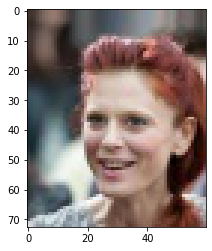

In [212]:
# Test that image look ok
plt.imshow(np.transpose(vutils.make_grid(data_train[1]['image'], padding=2,normalize=True).cpu(),(1,2,0)))

In [275]:
weight_df = pd.DataFrame(columns=train_df.columns)

weight_df = weight_df.drop(['partition','Smiling'],axis=1)
weight_df['Group'] = ['00','01','10','11']

target = 'Smiling'
for col in weight_df.columns:
    max_count = max(train_df.groupby([col,target]).count()['partition'].values)
    weight_df[col] = max_count/train_df.groupby([col,target]).count()['partition'].values

## 3. Testing for GPU

In [216]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [217]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


## 4. Defining model

In [218]:
height, width, channels = IMAGE_SHAPE

conv_out_channels =  16 # <-- Filters in your convolutional layer
kernel_size = 5       # <-- Kernel size
conv_stride = 1       # <-- Stride
conv_pad    = 0       # <-- Padding
 
def conv_dim(dim_size):
    return int(dim_size - kernel_size + 2 * conv_pad / conv_stride + 1)

conv1_h = conv_dim(height)//2
conv1_w = conv_dim(width)//2

# Keep track of features to output layer
features_cat_size = int(conv_out_channels * conv1_h * conv1_w)

conv2_h = conv_dim(conv1_h)//2
conv2_w = conv_dim(conv1_w)//2
        
features_cat_size2 = int(conv_out_channels*2 * conv2_h * conv2_w)

# <-- Number of features concatenated before output layer
  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv_out_channels,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        
        
        self.conv_2 = Conv2d(in_channels=conv_out_channels,
                             out_channels=conv_out_channels*2,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.dropout = Dropout2d(p=0.5)
        
        self.batch1 = BatchNorm2d(conv_out_channels)
        self.batch2 = BatchNorm2d(conv_out_channels*2)

             
        self.l_out = Linear(in_features=features_cat_size2,
                            out_features=NUM_CLASSES,
                            bias=False)
        
    def forward(self, x_img):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        features_img = self.pool(tanh(self.conv_1(x_img)))
        features_img = self.batch1(features_img)
        features_img = self.dropout(features_img)
        features_img = self.pool(tanh(self.conv_2(features_img)))
        features_img = self.batch2(features_img)
        
        features_img = features_img.view(-1, features_cat_size2)

        ## Output layer where all features are in use ##
        
        out['out'] = self.l_out(features_img)
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=5760, out_features=2, bias=False)
)


In [238]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss(reduction='none')  

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [239]:
# Function to get label
def get_labels(batch):
    return get_variable(Variable(batch['target']))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(batch['image']))
    }


## 5. Training model (happens on AWS) 

In [240]:
weight_df.columns[19:]

Index(['High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache',
       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose',
       'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

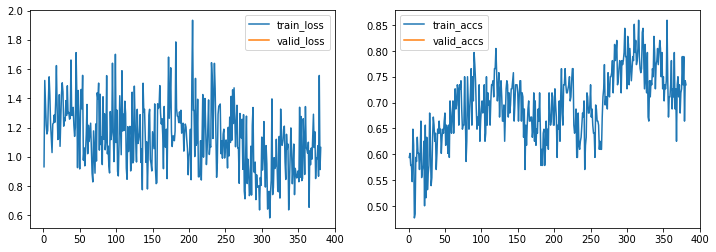

In [392]:
# Setup settings for training 
batch_size=128
max_iter = 199
log_every = 20
eval_every = 200
num_epochs = 2

protected_att = 19


# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen_train = DataLoader(data_train, batch_size, shuffle=True, num_workers=6)
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)

# Train network
j=0
net.train()
for epoch in range(num_epochs):
    for i, batch_train in enumerate(batch_gen_train):
        j+=1
        if i % eval_every == -1:
            

            # Do the validaiton
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            with torch.no_grad(): 
                for batch_valid in batch_gen_valid:
                    num = len(batch_valid['target'])
                    output = net(**get_input(batch_valid))
                    labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
                    val_losses += criterion(output['out'], labels_argmax) * num
                    val_accs += accuracy(output['out'], labels_argmax) * num
                    val_lengths += num

                # Divide by the total accumulated batch sizes
                val_losses /= val_lengths
                val_accs /= val_lengths
                valid_loss.append(get_numpy(val_losses))
                valid_accs.append(get_numpy(val_accs))
                valid_iter.append(j)
        #         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
                net.train()

        # Train network
        output = net(**get_input(batch_train))
        labels_argmax = torch.max(get_labels(batch_train), 1)[1]


        if weight_df is not None:
            protected = batch_train['attributes'][:,protected_att]
            l = [str(int(get_numpy(i))) + str(get_numpy(j)) for i, j in zip(protected, labels_argmax)]
            l_df = pd.DataFrame(l, columns=['Group'])
            batch_weights = pd.merge(l_df,weight_df,how='left',on='Group')
            loss = criterion(output['out'], labels_argmax)
            loss_weighted = torch.FloatTensor(batch_weights.iloc[:,protected_att+1].values)*loss
            batch_loss = torch.mean(loss_weighted) # Average across a batch
        else:
            batch_loss = criterion(output['out'], labels_argmax)


        train_iter.append(j)
        train_loss.append(float(get_numpy(batch_loss)))
        train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Log i figure
        if i % log_every == 0:
            fig = plt.figure(figsize=(12,4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='train_loss')
            plt.plot(valid_iter, valid_loss, label='valid_loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_iter, train_accs, label='train_accs')
            plt.plot(valid_iter, valid_accs, label='valid_accs')
            plt.legend()
            plt.show()
            clear_output(wait=True)
            #print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
            
        if max_iter == i:
            break

In [393]:
batch_loss

tensor(1.1622, grad_fn=<MeanBackward0>)

In [384]:
torch.FloatTensor(batch_weights.iloc[:,protected_att+1].values)*loss

tensor([1.1305e-02, 1.3330e-01, 2.3892e-01, 1.2262e+00, 3.3515e-02, 2.2930e+00,
        8.6961e-01, 1.1089e+00, 7.7401e+00, 7.7831e-01, 1.0136e+00, 4.6994e+00,
        5.3554e-01, 6.5271e-01, 6.7414e-01, 6.3204e-01, 1.0627e+01, 9.0330e-02,
        9.0819e+00, 2.4741e+00, 5.2080e-01, 1.9895e-01, 1.6330e-01, 5.6844e-01,
        7.9443e-02, 3.3199e-01, 2.0561e+00, 2.3230e+00, 3.6872e-01, 7.5763e-01,
        6.7609e-01, 3.6079e+00, 1.4856e+00, 2.4028e-01, 5.2502e-01, 1.1004e+00,
        5.3826e-03, 3.7694e+00, 1.5492e+00, 4.5652e+00, 3.0488e-02, 2.4615e-01,
        4.3882e-01, 3.4522e-01, 1.3291e+00, 8.4927e-01, 2.4996e-01, 8.9115e-01,
        9.1609e-01, 4.1484e-01, 2.2368e+00, 1.4079e+00, 7.1981e+00, 1.1642e+00,
        7.3591e-01, 2.9825e-01, 4.5911e+00, 6.9871e-01, 1.8444e+00, 1.1749e+00,
        3.3363e-01, 4.1244e-01, 2.5523e+00, 8.5852e-01, 1.2063e+00, 2.6582e+00,
        1.1029e+00, 5.7910e-01, 1.0059e+00, 1.4268e+00, 1.2513e+00, 1.3099e-01,
        1.5394e+00, 2.2670e-01, 1.5204e+

## 6. Loading trained model

#### Loading the dataframe defined when training the model

In [5]:
df = pd.read_pickle('df.pkl')

In [7]:
#defining which model in the df we want to look at. i becomes the row in the dataframe, hence a given model
i=1

#defining the rest of the informations
IMAGE_SHAPE = [73,60,3]
layers = df.loc[i,'layers']
activations = df.loc[i,'activations']
conv_out_channels = df.loc[i,'conv_out_channels']
kernel_size = df.loc[i,'kernel_size']
conv_stride = df.loc[i,'conv_stride']
maxpool = int(df.loc[i,'maxpool'])
dropout = df.loc[i,'dropout']
batchnorm = df.loc[i,'batchnorm']
optimizer = df.loc[i,'optimizer']
learning_rate = df.loc[i,'learning_rate']
weight_decay = df.loc[i,'weight_decay']
batch_size = int(df.loc[i,'batch_size'])
num_epochs = df.loc[i,'num_epochs']

#definging the network that suits the model loaded in the below cell
net = network_tuning.tune_architecture(layers, activations, IMAGE_SHAPE, conv_out_channels, kernel_size,conv_stride, maxpool, dropout, batchnorm)

#### Loading the model

In [9]:
#Loading the model which fits into the defined specifications above
net.load_state_dict(torch.load('model1'))
net.eval()

Net(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.0, inplace=False)
  (l_out): Linear(in_features=61824, out_features=2, bias=False)
)

#### Making accuracy estimates for all protected attributes against the target variable

In [356]:
#dataframe for saving predictions
valid_predictions = valid_df.astype(object)
valid_predictions.loc[:,'target'] = valid_predictions.loc[:,'Smiling']
valid_predictions.drop(['Smiling','partition'],axis=1)
valid_predictions['output'] = np.nan
valid_predictions['labels_argmax'] = np.nan
valid_predictions['accuracy'] = np.nan
valid_predictions['criterion'] = np.nan

In [357]:
#calculation predictions on the validation set
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
val_1_losses,val_1_accs,val_1_lengths,val_0_losses,val_0_accs,val_0_lengths = 0, 0, 0, 0, 0, 0
net.eval()
valid_predictions = valid_predictions.astype(object)
with torch.no_grad():
    for batch_valid in batch_gen_valid:
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
        for i in range(len(batch_valid['file'])):
            valid_predictions.at[batch_valid['file'][i],'output'] = output['out'][i]
            valid_predictions.at[batch_valid['file'][i],'labels_argmax'] = labels_argmax[i]
            valid_predictions.at[batch_valid['file'][i],'accuracy'] = accuracy(output['out'][i:i+1],labels_argmax[i:i+1])
            valid_predictions.at[batch_valid['file'][i],'criterion'] = criterion(output['out'][i:i+1],labels_argmax[i:i+1])

In [358]:
#calculating accuracies for all protected attributes
attributes = matched.iloc[:,0:-1].drop('Smiling',axis=1).columns
df_att = pd.DataFrame(index = attributes, columns=['val_1_loss','val_1_acc','val_0_loss','val_0_acc','val_1_FP','val_1_TP','val_0_FP','val_0_TP'])
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
for att in range(0,len(attributes)):
    print(attributes[att])
    
    att_ = valid_predictions.iloc[:][attributes[att]]
    t_ = valid_predictions.iloc[:]['target']
    
    att_1 = np.where(att_==1)
    att_0 = np.where(att_==0)
    
    att_1_t_1 = np.where((att_==1) & (t_==1))
    att_0_t_1 = np.where((att_==0) & (t_==1))
    att_1_t_0 = np.where((att_==1) & (t_==0))
    att_0_t_0 = np.where((att_==0) & (t_==0))
    
    df_att.iloc[att]['val_1_loss'] = np.mean(valid_predictions.iloc[att_1]['criterion'])
    df_att.iloc[att]['val_1_acc'] = np.mean(valid_predictions.iloc[att_1]['accuracy'])
    df_att.iloc[att]['val_0_loss'] = np.mean(valid_predictions.iloc[att_0]['criterion'])
    df_att.iloc[att]['val_0_acc'] = np.mean(valid_predictions.iloc[att_0]['accuracy'])
    df_att.iloc[att]['val_1_FP'] = 1-np.mean(valid_predictions.iloc[att_1_t_0]['accuracy'])
    df_att.iloc[att]['val_0_FP'] = 1-np.mean(valid_predictions.iloc[att_0_t_0]['accuracy'])
    df_att.iloc[att]['val_1_TP'] = np.mean(valid_predictions.iloc[att_1_t_1]['accuracy'])
    df_att.iloc[att]['val_0_TP'] = np.mean(valid_predictions.iloc[att_0_t_1]['accuracy'])

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [359]:
df_att['TP_OR'] = df_att['val_1_TP'] /df_att['val_0_TP'] 
df_att['FP_OR'] = df_att['val_1_FP'] /df_att['val_0_FP'] 

In [360]:
df_att

,val_1_loss,val_1_acc,val_0_loss,val_0_acc,val_1_FP,val_1_TP,val_0_FP,val_0_TP,TP_OR,FP_OR
5_o_Clock_Shadow,0.792938,0.528785,0.676832,0.616596,0.667592,0.841814,0.607888,0.844332,0.997018,1.09822
Arched_Eyebrows,0.64477,0.644332,0.706483,0.592955,0.639352,0.860625,0.609896,0.836896,1.02835,1.0483
Attractive,0.6559,0.640728,0.728068,0.568852,0.635698,0.854861,0.601043,0.827513,1.03305,1.05766
Bags_Under_Eyes,0.653561,0.644018,0.700215,0.596342,0.627851,0.828513,0.614025,0.849447,0.975356,1.02252
Bald,0.652372,0.635036,0.691342,0.605623,0.601036,0.844037,0.616561,0.844096,0.999929,0.974821
Bangs,0.663054,0.619897,0.69526,0.603882,0.624636,0.83733,0.614978,0.84539,0.990466,1.0157
Big_Lips,0.661987,0.621551,0.695702,0.60346,0.543776,0.824908,0.630445,0.847274,0.973602,0.862527
Big_Nose,0.657176,0.65001,0.701586,0.591731,0.603801,0.830163,0.619384,0.850097,0.976551,0.974842
Black_Hair,0.685514,0.627413,0.69186,0.600649,0.510801,0.787201,0.645406,0.858333,0.917127,0.791442
Blond_Hair,0.634216,0.656414,0.700773,0.597109,0.764017,0.926384,0.596803,0.824312,1.12383,1.28018


In [361]:
#Mean accuracy 
np.mean(valid_predictions['accuracy'])

0.6062314390698142

In [362]:
df_att['TP_OR'] = pd.to_numeric(df_att['TP_OR'])
df_att['FP_OR'] = pd.to_numeric(df_att['FP_OR'])

## 7. Plotting biases

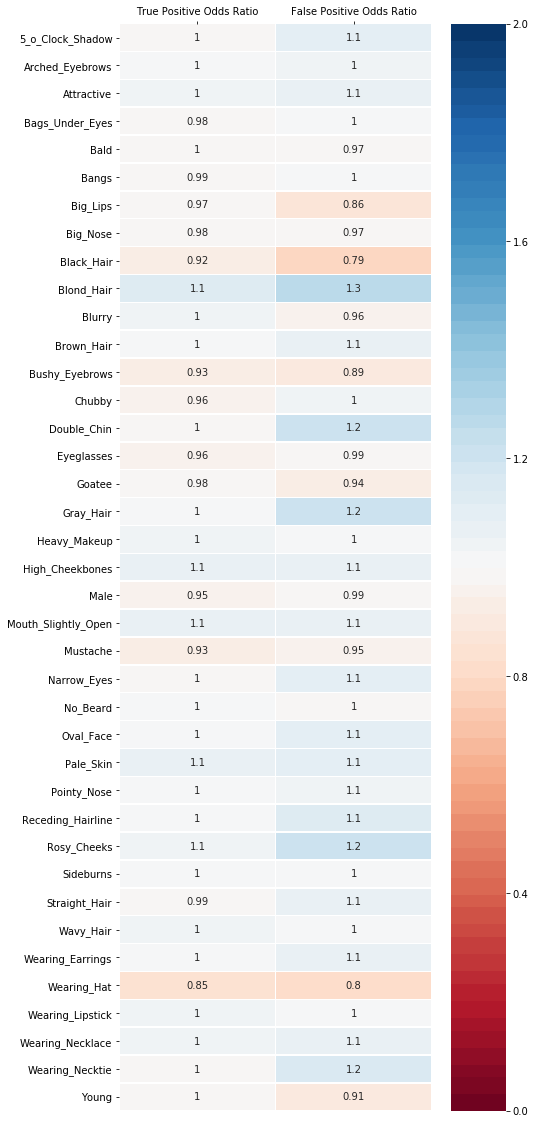

In [363]:
import seaborn as sns
plt.figure(figsize = (7,20))
cmap=sns.color_palette("RdBu",70)
heatmap_kwargs = dict(vmin=0, vmax=2, cmap=cmap,annot=True, linewidths=.5)
ax = sns.heatmap(df_att[['TP_OR','FP_OR']], center=1.0, **heatmap_kwargs)
ax.set_xticklabels(['True Positive Odds Ratio','False Positive Odds Ratio'])
ax.set_yticklabels(list(df_att.index))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.xaxis.set_ticks_position('top')

In [45]:
valid_predictions

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition,target,output,labels_argmax,accuracy,criterion
im_id,,,,,,,,,,,,,,,,,,,,,
162771.jpg,0,0,1,0,0,1,1,0,0,0,...,1,0,0,1,1,1,"[tensor(1.0983), tensor(-1.1607)]",tensor(1),tensor(0.),tensor(2.3583)
162772.jpg,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,1,1,"[tensor(0.7469), tensor(-0.6975)]",tensor(1),tensor(0.),tensor(1.6562)
162773.jpg,0,1,1,0,0,0,1,0,0,0,...,1,0,0,1,1,0,"[tensor(3.6774), tensor(-3.6774)]",tensor(0),tensor(1.),tensor(0.0006)
162774.jpg,1,0,1,0,0,0,0,0,0,0,...,0,0,1,1,1,1,"[tensor(-2.7791), tensor(2.7476)]",tensor(1),tensor(1.),tensor(0.0040)
162775.jpg,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,1,0,"[tensor(4.6056), tensor(-4.5879)]",tensor(0),tensor(1.),tensor(0.0001)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182633.jpg,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,1,0,"[tensor(1.2720), tensor(-1.3230)]",tensor(0),tensor(1.),tensor(0.0720)
182634.jpg,0,0,0,0,0,0,1,1,0,0,...,0,0,0,1,1,0,"[tensor(2.9247), tensor(-2.9059)]",tensor(0),tensor(1.),tensor(0.0029)
182635.jpg,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,1,1,"[tensor(-0.6727), tensor(0.6522)]",tensor(1),tensor(1.),tensor(0.2357)


In [43]:
#funtion to show image along with output and true target
def show_batch(sample_batched, bias_idx):
    """Show image with landmarks for a batch of samples."""
    images_batch, target_batch, bias = \
            sample_batched['image'], sample_batched['target'], sample_batched['attributes'][:,bias_idx]
    
    batch_size = len(images_batch)
    for i in range(batch_size):

        #grid = utils.make_grid(images_batch)
        plt.figure()
        plt.imshow(np.transpose(vutils.make_grid(images_batch[i], padding=2,normalize=True).cpu(),(1,2,0)))
        plt.axis('off')
        plt.ioff()
        plt.show()
        print(target_batch[i])
        print(bias[i])
        print(output['out'][i])

In [59]:
attributes[21]

'Mouth_Slightly_Open'

<Figure size 432x288 with 0 Axes>

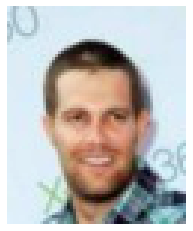

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.2282,  2.1923])


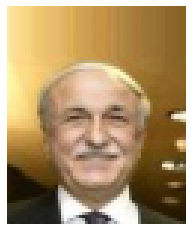

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([-1.8043,  1.7955])


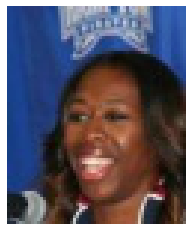

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.4621,  2.4433])


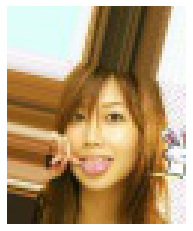

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.0475,  2.0886])


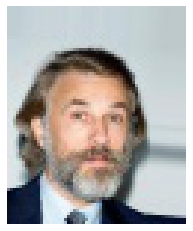

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.0327, -1.0336])


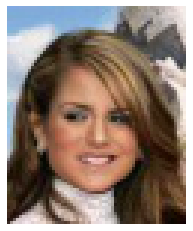

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.7887,  2.7685])


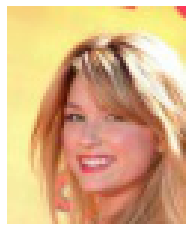

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.2400,  2.2358])


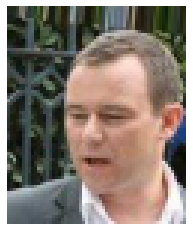

tensor([1., 0.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([ 2.4823, -2.4983])


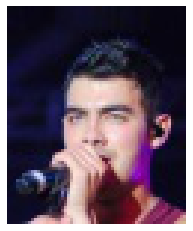

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.5282, -1.6069])


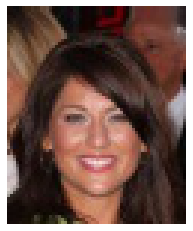

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-4.8122,  4.7870])


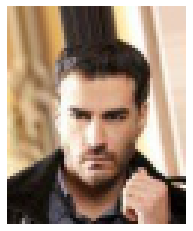

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 4.3442, -4.3708])


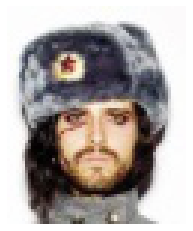

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 2.5473, -2.4839])


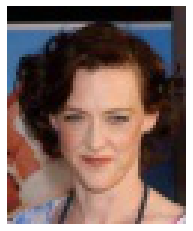

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([-0.1575,  0.1739])


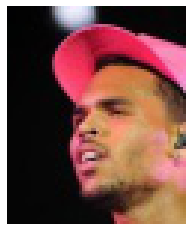

tensor([1., 0.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([ 1.7940, -1.8321])


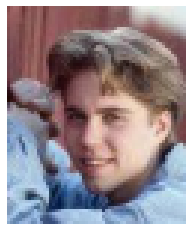

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-0.1426,  0.1143])


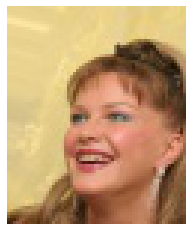

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.2661,  2.2854])


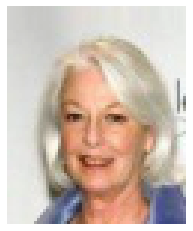

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.4169,  2.3552])


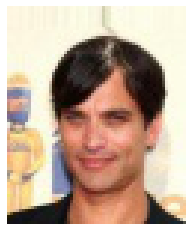

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([-1.9736,  1.9671])


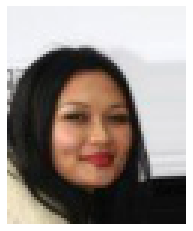

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([-1.2526,  1.2529])


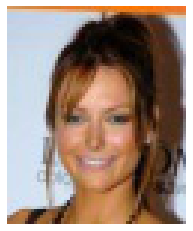

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.9960,  2.9459])


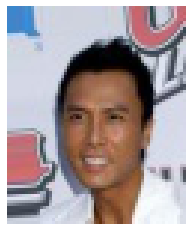

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-0.6736,  0.6423])


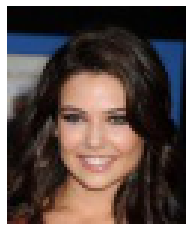

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-4.2605,  4.2334])


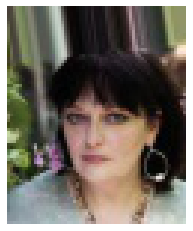

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.5773, -1.6364])


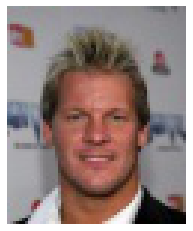

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-0.8486,  0.8297])


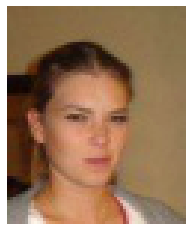

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.0749, -1.0985])


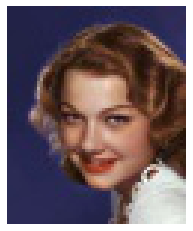

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-1.7983,  1.7473])


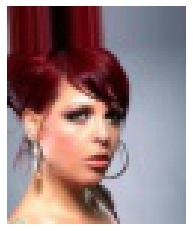

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 2.4696, -2.4649])


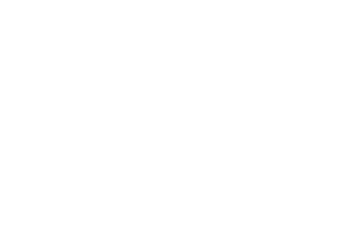

In [60]:
plt.figure()
show_batch(batch_valid,21)
plt.axis('off')
plt.ioff()
plt.show()